## Importing Libraries and Reading the Data

In [38]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import os
import re
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/[Reddit] polestar_posts_comments by praw.csv')
data.head()

,post_title,post_body,post_score,post_created_utc,comment_body,comment_score,comment_created_utc
0,"Polestar 4 prices revealed: $26,800 cheaper th...",NaN,198,2023-10-31 10:56:46,The title should have had this info in it. \n\...,75,2023-10-31 12:26:21
1,"Polestar 4 prices revealed: $26,800 cheaper th...",NaN,198,2023-10-31 10:56:46,The P*2 is/was a bargain at its launch. I am ...,27,2023-10-31 12:42:19
2,"Polestar 4 prices revealed: $26,800 cheaper th...",NaN,198,2023-10-31 10:56:46,Those prices have to go down; too much competi...,72,2023-10-31 12:38:41
3,"Polestar 4 prices revealed: $26,800 cheaper th...",NaN,198,2023-10-31 10:56:46,Best I can tell this is based on a direct tran...,17,2023-10-31 13:23:31
4,"Polestar 4 prices revealed: $26,800 cheaper th...",NaN,198,2023-10-31 10:56:46,FYI This is not official pricing.,10,2023-10-31 13:29:55


In [2]:
data.isnull().sum()

post_title                0
post_body              2265
post_score                0
post_created_utc          0
comment_body             20
comment_score             0
comment_created_utc       0
dtype: int64

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8964 entries, 0 to 8963
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   post_title           8964 non-null   object
 1   post_body            6699 non-null   object
 2   post_score           8964 non-null   int64 
 3   post_created_utc     8964 non-null   object
 4   comment_body         8944 non-null   object
 5   comment_score        8964 non-null   int64 
 6   comment_created_utc  8964 non-null   object
dtypes: int64(2), object(5)
memory usage: 490.3+ KB


In [4]:
data.describe(include = "all")

,post_title,post_body,post_score,post_created_utc,comment_body,comment_score,comment_created_utc
count,8964,6699,8964.000000,8964,8944,8964.000000,8964
unique,222,178,NaN,227,8697,NaN,8953
top,Here is the brand new Polestar 4,"Macan EV just dropped, starting at $80k base, ...",NaN,2023-04-17 19:21:35,[deleted],NaN,2023-11-27 20:45:15
freq,328,232,NaN,328,104,NaN,2
mean,NaN,NaN,107.030009,NaN,NaN,3.467983,NaN
std,NaN,NaN,155.709614,NaN,NaN,7.322292,NaN
min,NaN,NaN,0.000000,NaN,NaN,-37.000000,NaN
25%,NaN,NaN,11.000000,NaN,NaN,1.000000,NaN
50%,NaN,NaN,34.000000,NaN,NaN,2.000000,NaN
75%,NaN,NaN,129.000000,NaN,NaN,3.000000,NaN


In [5]:
data = data.dropna(subset=['comment_body'])

## Exploratory Data Analysis

In [41]:
data['post_created_utc'] = pd.to_datetime(data['post_created_utc'])
data['comment_created_utc'] = pd.to_datetime(data['comment_created_utc'])

fig_post_scores = px.histogram(data, x='post_score', nbins=50, title='Distribution of Post Scores')
fig_post_scores.update_layout(xaxis_title='Post Score', yaxis_title='Count', bargap=0.2)
fig_comment_scores = px.histogram(data, x='comment_score', nbins=50, title='Distribution of Comment Scores')
fig_comment_scores.update_layout(xaxis_title='Comment Score', yaxis_title='Count', bargap=0.2)

fig_post_scores.show()
fig_comment_scores.show()

In [42]:
posts_per_day = data.groupby(data['post_created_utc'].dt.date)['post_title'].count().reset_index(name='post_count')
posts_per_day['post_created_utc'] = pd.to_datetime(posts_per_day['post_created_utc'])

fig_posts_activity = px.line(posts_per_day, x='post_created_utc', y='post_count', title='Posts Activity Over Time')
fig_posts_activity.update_layout(xaxis_title='Date', yaxis_title='Number of Posts', xaxis_rangeslider_visible=True)
fig_posts_activity.show()

In [43]:
comments_per_day = data.groupby(data['comment_created_utc'].dt.date)['comment_body'].count().reset_index(name='comment_count')
comments_per_day['comment_created_utc'] = pd.to_datetime(comments_per_day['comment_created_utc'])  # Ensuring datetime format

fig_comments_activity = px.line(comments_per_day, x='comment_created_utc', y='comment_count', title='Comments Activity Over Time')
fig_comments_activity.update_layout(xaxis_title='Date', yaxis_title='Number of Comments', xaxis_rangeslider_visible=True)
fig_comments_activity.show()

In [44]:
top_posts = data.groupby(['post_title', 'post_created_utc'])['post_score'].max().reset_index()
top_posts_sorted = top_posts.sort_values(by='post_score', ascending=False).head(10)

fig_top_posts = px.bar(top_posts_sorted, x='post_score', y='post_title', orientation='h',
                       title='Top 10 Posts by Score',
                       labels={'post_title': 'Post Title', 'post_score': 'Post Score'})
fig_top_posts.update_layout(yaxis={'categoryorder': 'total ascending'}, xaxis_title='Score', yaxis_title='Post Title')
fig_top_posts.show()

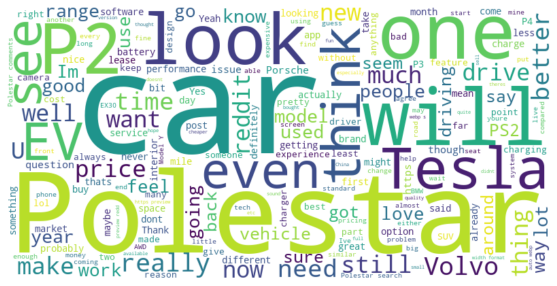

In [45]:
all_comments_text = ' '.join(data['comment_body'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# temp_post = list(data["post_title"].unique())
# df = data["comment_body"]
# temp = list(df)
# final_list = temp + temp_post
# dataset = pd.DataFrame({"comments_post": final_list})

## Cleaning the comments

In [16]:
dataset = pd.DataFrame({"comments": data["comment_body"]}).reset_index(drop = True)

corpus = []
words = []
cloud = []
ps = PorterStemmer()
for i in range(0, len(dataset)):
    review2 = dataset['comments'][i]
    review2 = re.sub('"', ' ', review2)
    review2 = re.sub('https://[a-zA-Z0-9./]+', ' ',review2)
    review2 = re.sub('#[a-zA-Z0-9._]+', ' ', review2)
    review2 = re.sub('@[a-zA-Z0-9._]+', ' ', review2)
    review2 = re.sub('\n', ' ', review2)
    review2 = re.sub('&amp', ' ', review2)
    review2 = re.sub('[^a-zA-Z]', ' ', review2)
    review2 = review2.lower()
    review2 = review2.split()
    review2 = [word for word in review2 if not word in stopwords.words('english')]
    for j in review2:
        words.append(j)
        cloud.append(' '.join(j))
    review2 = [ps.stem(word) for word in review2]
    review2 = ' '.join(review2)
    corpus.append(review2)

dataset = pd.DataFrame({"comments": corpus}).reset_index(drop = True)

,comments
0,The title should have had this info in it. \n\...
1,The P*2 is/was a bargain at its launch. I am ...
2,Those prices have to go down; too much competi...
3,Best I can tell this is based on a direct tran...
4,FYI This is not official pricing.
...,...
8939,"If that's the case, creep wouldn't help agains..."
8940,Press it to set a new speed and report back.
8941,Press the center button to set a new speed and...
8942,Fair enough


## Labelling the data (using polarity)

In [21]:
dataset['sentiment'] = ' '
dataset['polarity'] = None
for i,j in enumerate(dataset.comments):
    blob = TextBlob(j)
    dataset['polarity'][i] = blob.sentiment.polarity
    if blob.sentiment.polarity > 0 :
        dataset['sentiment'][i] = 'positive'
    elif blob.sentiment.polarity == 0 :
        dataset['sentiment'][i] = 'neutral'
    else:
        dataset['sentiment'][i] = 'negative'
dataset

,comments,sentiment,polarity
0,titl info save click polestar carri start pric...,neutral,0.0
1,p bargain launch fortun catch canadian rebat f...,positive,0.136591
2,price go much competit area,positive,0.2
3,best tell base direct translat dutch english u...,negative,-0.1
4,fyi offici price,neutral,0.0
...,...,...,...
8939,case creep help rust,neutral,0.0
8940,press set new speed report back,positive,0.068182
8941,press center button set new speed see happen s...,positive,0.159091
8942,fair enough,positive,0.35


In [24]:
fig = px.histogram(dataset, x='sentiment', title="Sentiments",
                   labels={'sentiment': 'Sentiment'},
                   category_orders={"sentiment": ["Positive", "Neutral", "Negative"]})  # Assuming these are the potential categories
fig.update_layout(xaxis_title='Sentiment', yaxis_title='Count',
                  title={'text': "Sentiments", 'x':0.5, 'xanchor': 'center'},
                  template='plotly_white')
# fig.update_traces(marker_color='blue')
fig.show()

In [25]:
labelEncoder_X = LabelEncoder()
dataset['sentiment'] = labelEncoder_X.fit_transform(dataset['sentiment'])
dataset.head(5)

,comments,sentiment,polarity
0,titl info save click polestar carri start pric...,1,0.0
1,p bargain launch fortun catch canadian rebat f...,2,0.136591
2,price go much competit area,2,0.2
3,best tell base direct translat dutch english u...,0,-0.1
4,fyi offici price,1,0.0


In [26]:
df2 = pd.DataFrame(words)
df2 = df2[0].value_counts()

freqdist2 = FreqDist()

for word_ in df2:
    freqdist2[word_] += 1

freqdist2

FreqDist({1: 5646, 2: 1837, 3: 1017, 4: 618, 5: 472, 6: 363, 7: 239, 8: 230, 9: 187, 10: 153, ...})

In [46]:
temp = df2[:20]
fig = px.bar(temp, y=temp.index, x=temp.values, orientation='h',
             title="Top Words Used",
             labels={'index': 'Words', 'Count': 'Count'})
fig.update_layout(xaxis_title='Count', yaxis_title='Words',
                  title={'text': "Top Words Used post cleaning", 'x':0.5, 'xanchor': 'center'},
                  template='plotly_white', height=800)
fig.show()

In [32]:
dataset_final = pd.DataFrame(corpus, columns = ['Content'])  # To convert a List into a DataFrame
dataset_final = pd.concat([dataset['sentiment'], dataset_final], axis = 1)
dataset_final

,sentiment,Content
0,1,titl info save click polestar carri start pric...
1,2,p bargain launch fortun catch canadian rebat f...
2,2,price go much competit area
3,0,best tell base direct translat dutch english u...
4,1,fyi offici price
...,...,...
8939,1,case creep help rust
8940,2,press set new speed report back
8941,2,press center button set new speed see happen s...
8942,2,fair enough


## Using TFIDF Vectorizer

In [33]:
vectorizer = TfidfVectorizer(min_df = 3, max_df = 0.9, max_features = 3600000)
# max_df is used for removing terms that appear too frequently
# max_df = 0.90 means "ignore terms that appear in more than 90% of the documents".
# min_df is used for removing terms that appear too infrequently
# min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".

X = vectorizer.fit_transform(dataset_final.Content)
y = dataset_final.iloc[:, 0].values

## Splitting the data into Train and Test

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Model Pipelines

### Logistic Regression

Accuracy of Logistic Regression is: 85.68872987477639%
              precision    recall  f1-score   support

           0       0.93      0.48      0.63       380
           1       0.83      0.96      0.89       843
           2       0.86      0.91      0.89      1013

    accuracy                           0.86      2236
   macro avg       0.88      0.78      0.80      2236
weighted avg       0.86      0.86      0.85      2236



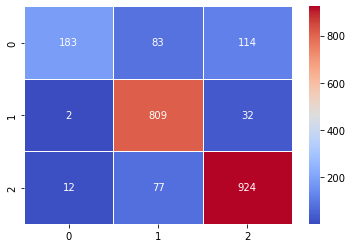

In [39]:
classifier_log = LogisticRegression(max_iter = 300)
classifier_log.fit(X_train, Y_train)

Y_pred_log = classifier_log.predict(X_test)

print("Accuracy of Logistic Regression is: {}%".format(accuracy_score(Y_test, Y_pred_log) * 100))
# print("Confusion Matrix of Logistic Regression is: \n{}".format(confusion_matrix(Y_test, Y_pred_log)))
sns.heatmap(confusion_matrix(Y_test, Y_pred_log), linecolor = 'white', linewidths = 1, cmap = 'coolwarm', annot = True, fmt='g')
print("{}".format(classification_report(Y_test, Y_pred_log)))

### Random Forest

Accuracy of Random Forest Classifier is: 87.07513416815742%
              precision    recall  f1-score   support

           0       0.95      0.47      0.63       380
           1       0.89      0.96      0.92       843
           2       0.84      0.95      0.89      1013

    accuracy                           0.87      2236
   macro avg       0.89      0.79      0.82      2236
weighted avg       0.88      0.87      0.86      2236



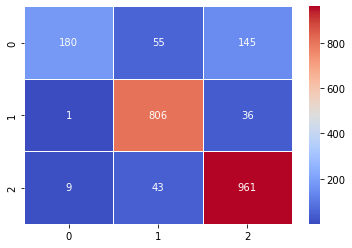

In [40]:
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
classifier_rf.fit(X_train, Y_train)

Y_pred_rf = classifier_rf.predict(X_test)

print("Accuracy of Random Forest Classifier is: {}%".format(accuracy_score(Y_test, Y_pred_rf) * 100))
# print("Confusion Matrix of Random Forest Classifier is: \n{}".format(confusion_matrix(Y_test, Y_pred_rf)))
sns.heatmap(confusion_matrix(Y_test, Y_pred_rf), linecolor = 'white', linewidths = 1, cmap = 'coolwarm', annot = True, fmt='g')
print("{}".format(classification_report(Y_test, Y_pred_rf)))